In [1]:
# Import system packages
import os
import sys
import time
import logging
import importlib

#Import data manipulation libraries
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm

#Import visualization libraries
import matplotlib.pyplot as plt

#Importing ML/DL libraries
# from sklearn.preprocessing import MinMaxScaler, label
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
from sklearn.preprocessing import LabelEncoder
# -----------------------------

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow import keras
# from tensorflow.keras import layer

from keras import initializers # type: ignore
from keras.models import Model, Sequential # type: ignore
from keras.optimizers import Adam, RMSprop # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
from tensorflow.keras.layers import LeakyReLU # type: ignore
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation  # type: ignore
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate # type: ignore
import pickle

import random
random.seed(123)

data_path = './data/'

In [2]:
pct_anomalies = .01

In [3]:
!python preprocess_data.py --pct_anomalies $pct_anomalies

Final feature space dimensionality: 122


In [4]:
#loading the pickled file

filename = 'preprocessed_data_full.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [5]:
for key in preprocessed_data:
    print(key)  

x_train
y_train
x_test
y_test
le


In [6]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [7]:
np.unique(y_train)

array([ 0,  5,  9, 10, 11, 15, 17, 18, 21])

In [8]:
#Obtain the class number for Normal entries 
pd.DataFrame(le.classes_, columns = ['Type'])

,Type
0,back.
1,buffer_overflow.
2,ftp_write.
3,guess_passwd.
4,imap.
5,ipsweep.
6,land.
7,loadmodule.
8,multihop.
9,neptune.


In [9]:
# Converting labels to Binary

y_test[y_test != 11] = 1 
y_test[y_test == 11] = 0
y_train[y_train != 11] = 1
y_train[y_train == 11] = 0

In [10]:
#Subsetting only Normal Network packets in our training set

temp_df = x_train.copy()
temp_df['label'] = y_train
temp_df = temp_df.loc[temp_df['label'] == 0]
temp_df = temp_df.drop('label', axis = 1)
x_train = temp_df.copy()

In [11]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Creating dataset dictionary 
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

In [12]:
# check how many anomalies are in our Testing set
print('Number of Normal Network packets in the Training set:', x_train.shape[0])
print('Number of Normal Network packets in the Testing set:', collections.Counter(y_test)[0])
print('Number of Anomalous Network packets in the Testing set:', collections.Counter(y_test)[1])

Number of Normal Network packets in the Training set: 729620
Number of Normal Network packets in the Testing set: 243161
Number of Anomalous Network packets in the Testing set: 2466


In [13]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=122, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(122, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

In [14]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=122, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

In [15]:
def get_gan_network(discriminator, generator, optimizer,input_dim=122):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [16]:
learning_rate = 0.00001
batch_size = 512
epochs = 10
adam_gen = Adam(learning_rate=learning_rate, beta_1=0.5)
adam_dis = Adam(learning_rate=learning_rate, beta_1=0.5)
adam_gan = Adam(learning_rate=learning_rate, beta_1=0.5)


In [17]:
#Training the GAN
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'],dataset['x_test'],dataset['y_test']

#Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam_gen)
discriminator = get_discriminator(adam_dis)
gan = get_gan_network(discriminator, generator, adam_gan,input_dim=122)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,122])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, 122])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))

  0%|          | 0/14250 [00:00<?, ?it/s]C:\Users\arjun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
 10%|█         | 1427/14250 [02:16<20:46, 10.29it/s]

Epoch 0 Batch 1424/1425 [D loss: 0.378100] [G loss:0.282350]


 20%|██        | 2851/14250 [04:33<18:33, 10.24it/s]

Epoch 1 Batch 1424/1425 [D loss: 0.224958] [G loss:0.149527]


 30%|███       | 4277/14250 [06:50<15:51, 10.48it/s]

Epoch 2 Batch 1424/1425 [D loss: 0.159391] [G loss:0.100221]


 40%|████      | 5703/14250 [09:06<13:27, 10.59it/s]

Epoch 3 Batch 1424/1425 [D loss: 0.123511] [G loss:0.075345]


 50%|█████     | 7127/14250 [11:22<11:17, 10.52it/s]

Epoch 4 Batch 1424/1425 [D loss: 0.102398] [G loss:0.060404]


 60%|██████    | 8553/14250 [13:38<08:54, 10.65it/s]

Epoch 5 Batch 1424/1425 [D loss: 0.086897] [G loss:0.050379]


 70%|███████   | 9977/14250 [15:54<06:47, 10.49it/s]

Epoch 6 Batch 1424/1425 [D loss: 0.076153] [G loss:0.043395]


 80%|████████  | 11401/14250 [18:10<04:31, 10.51it/s]

Epoch 7 Batch 1424/1425 [D loss: 0.067761] [G loss:0.038037]


 90%|█████████ | 12827/14250 [20:27<02:16, 10.43it/s]

Epoch 8 Batch 1424/1425 [D loss: 0.061011] [G loss:0.033834]


100%|█████████▉| 14249/14250 [22:42<00:00, 10.47it/s]

Epoch 9 Batch 1424/1425 [D loss: 0.055274] [G loss:0.030460]


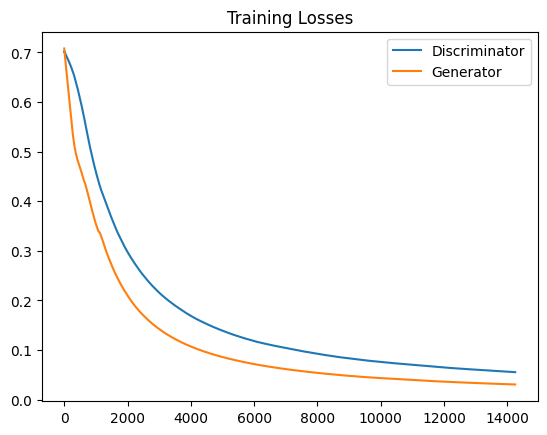

In [18]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [19]:
# Predictions on the test set

nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = x_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

C:\Users\arjun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
100%|██████████| 14250/14250 [23:00<00:00, 10.47it/s]

In [20]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for normal packets :', results_df.loc[results_df['y_test'] == 0, 'results'].mean() )
print ('Mean score for anomalous packets :', results_df.loc[results_df['y_test'] == 1, 'results'].mean())

Mean score for normal packets : 0.9995544909760773
Mean score for anomalous packets : 0.05832765958028557


In [21]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [22]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.9990595496423439
Precision : 0.9548229548229549
Recall : 0.9513381995133819
F1 : 0.9530773918342474


Confusion Matrix :


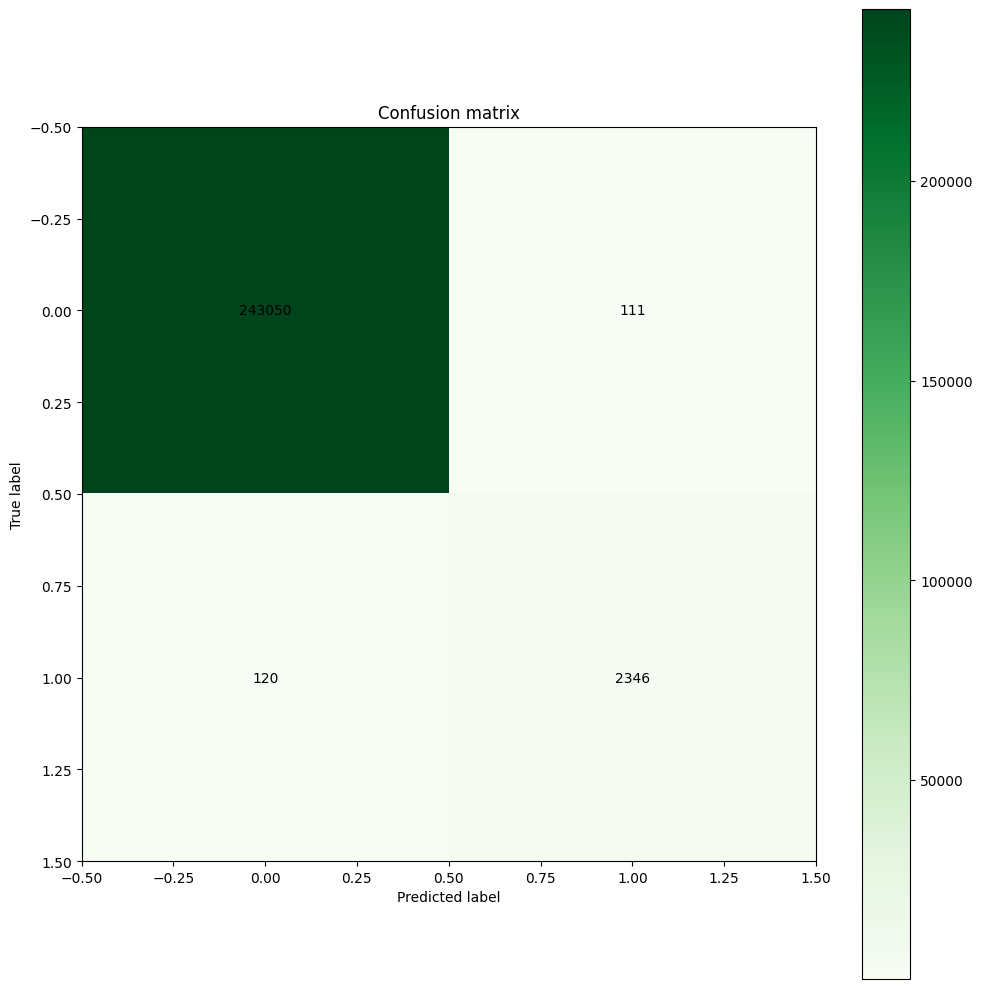

In [23]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

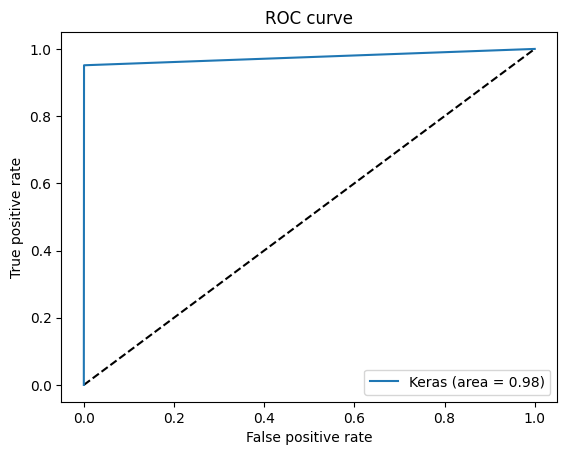

In [24]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [25]:
# --- Append at the end of your training notebook ---

# 1. Save the discriminator and generator
discriminator.save('discriminator_saved_model.keras')      # Folder of SavedModel
generator.save('generator_saved_model.keras')

